In [23]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial import KDTree
import time
import os

# --- Configuration ---
DT = 0.05           # Faster updates for stability
N_HORIZON = 20      # Look further ahead (1.0s horizon)
L_VEHICLE = 0.33    # 1/10 Scale Car
W_TRACK = 4.0       # Track width
N_LAPS = 10         # Increased laps to see learning
FILENAME = 'raceline.csv'

# 1. TRACK MANAGER
class TrackManager:
    def __init__(self, filename, width=4.0):
        self.width = width
        self.path = None
        
        if os.path.exists(filename):
            print(f"Loading track from {filename}...")
            try:
                data = np.loadtxt(filename, delimiter=',', skiprows=1)
                self.path = data[:, :2]
            except:
                self.generate_fallback_track()
        else:
            print("raceline.csv not found. Generating Scaled Fallback Track.")
            self.generate_fallback_track()
            
        self.N_points = self.path.shape[0]
        self.kdtree = KDTree(self.path)
        self.process_path()

    def generate_fallback_track(self):
        theta = np.linspace(0, 2*np.pi, 1000)
        a, b = 70.0, 40.0 
        x = a * np.cos(theta)
        y = b * np.sin(theta)
        self.path = np.vstack((x, y)).T

    def process_path(self):
        x, y = self.path[:, 0], self.path[:, 1]
        dx, dy = np.gradient(x), np.gradient(y)
        ddx, ddy = np.gradient(dx), np.gradient(dy)
        
        self.headings = np.arctan2(dy, dx)
        
        # Curvature calculation
        denom = (dx**2 + dy**2)**1.5 + 1e-6
        self.curvature = (dx * ddy - dy * ddx) / denom
        
        # Boundaries
        norm = np.sqrt(dx**2 + dy**2) + 1e-6
        nx, ny = -dy/norm, dx/norm
        self.inner = np.vstack((x + nx*self.width/2, y + ny*self.width/2)).T
        self.outer = np.vstack((x - nx*self.width/2, y - ny*self.width/2)).T

    def get_reference(self, x_car, y_car, horizon):
        _, idx = self.kdtree.query([x_car, y_car])
        
        indices = np.arange(idx, idx + horizon + 1) % self.N_points
        
        ref_x = self.path[indices, 0]
        ref_y = self.path[indices, 1]
        ref_psi = np.unwrap(self.headings[indices])
        
        # Physics-Based Speed Limit
        k_max = np.max(np.abs(self.curvature[indices]))
        v_limit = np.sqrt(6.0 / (k_max + 1e-3)) 
        v_limit = np.clip(v_limit, 2.0, 18.0) 
        
        return ref_x, ref_y, ref_psi, v_limit, idx

# 2. LMPC LEARNER
class LMPCLearner:
    def __init__(self):
        self.X, self.U, self.X_next, self.X_nom = None, None, None, None
        self.tree = None
        self.Ae = np.zeros((4,4))
        self.Be = np.zeros((4,2))
        self.Ce = np.zeros((4,1))
        # Store previous control here for convenience
        self.prev_u = np.array([0.0, 0.0])

    def add_data(self, X, U, X_next, X_nom):
        if self.X is None:
            self.X, self.U = X, U
            self.X_next, self.X_nom = X_next, X_nom
        else:
            self.X = np.vstack((self.X, X))
            self.U = np.vstack((self.U, U))
            self.X_next = np.vstack((self.X_next, X_next))
            self.X_nom = np.vstack((self.X_nom, X_nom))
        self.tree = KDTree(self.X[:, :2])

    def update_error_model(self, x_curr):
        if self.X is None: return
        
        dist, idx = self.tree.query(x_curr[:2], k=15)
        
        # Epanechnikov weights
        h = 3.0
        w = np.where(dist/h < 1, 0.75*(1-(dist/h)**2), 0.0)
        
        if np.sum(w) < 1e-3: return 
        
        W = np.diag(w)
        X_loc = self.X[idx]; U_loc = self.U[idx]
        E_loc = self.X_next[idx] - self.X_nom[idx]
        
        ones = np.ones((len(idx), 1))
        Z = np.hstack((X_loc, U_loc, ones))
        
        try:
            reg = 1e-4 * np.eye(Z.shape[1])
            Theta = np.linalg.inv(Z.T @ W @ Z + reg) @ Z.T @ W @ E_loc
            Theta = Theta.T 
            
            # Inertia Update
            alpha = 0.1
            self.Ae = (1-alpha)*self.Ae + alpha*np.clip(Theta[:, 0:4], -2, 2)
            self.Be = (1-alpha)*self.Be + alpha*np.clip(Theta[:, 4:6], -2, 2)
            self.Ce = (1-alpha)*self.Ce + alpha*np.clip(Theta[:, 6:7], -1, 1)
        except:
            pass

# 3. CASADI MPC (FIXED)
class CasadiMPC:
    def __init__(self):
        self.opti = ca.Opti()
        self.N = N_HORIZON
        
        # Vars
        self.X = self.opti.variable(4, self.N + 1) # x, y, v, psi
        self.U = self.opti.variable(2, self.N)     # acc, delta
        
        # Params
        self.P_x0    = self.opti.parameter(4)
        self.P_ref   = self.opti.parameter(3, self.N + 1)
        self.P_v_tgt = self.opti.parameter(1)
        self.P_Ae    = self.opti.parameter(4, 4)
        self.P_Be    = self.opti.parameter(4, 2)
        self.P_Ce    = self.opti.parameter(4, 1)
        
        # --- NEW: Previous Control Param ---
        self.P_u_prev = self.opti.parameter(2)

        # Objective
        cost = 0
        for k in range(self.N):
            # 1. Path Tracking (LOWERED WEIGHT: 20 -> 2.0)
            err_path = 2.0 * ((self.X[0, k] - self.P_ref[0, k])**2 + \
                              (self.X[1, k] - self.P_ref[1, k])**2)
            
            # 2. Velocity Tracking
            err_vel = 1.0 * (self.X[2, k] - self.P_v_tgt)**2
            
            # 3. Input Regularization
            reg_u = 0.1 * self.U[0, k]**2 + 1.0 * self.U[1, k]**2 
            
            # --- 4. NEW: Slew Rate Damping ---
            if k == 0:
                delta_u_acc = (self.U[0, k] - self.P_u_prev[0])**2
                delta_u_steer = (self.U[1, k] - self.P_u_prev[1])**2
            else:
                delta_u_acc = (self.U[0, k] - self.U[0, k-1])**2
                delta_u_steer = (self.U[1, k] - self.U[1, k-1])**2
            
            # Heavy penalty on steering changes
            damping = 5.0 * delta_u_acc + 200.0 * delta_u_steer
            
            cost += err_path + err_vel + reg_u + damping
            
        self.opti.minimize(cost)

        # Dynamics Constraints
        for k in range(self.N):
            x_k = self.X[:, k]
            u_k = self.U[:, k]
            
            beta = ca.atan(0.5 * ca.tan(u_k[1]))
            x_nom = ca.vertcat(
                x_k[0] + x_k[2] * ca.cos(x_k[3] + beta) * DT,
                x_k[1] + x_k[2] * ca.sin(x_k[3] + beta) * DT,
                x_k[2] + u_k[0] * DT,
                x_k[3] + (x_k[2] / L_VEHICLE) * ca.sin(beta) * DT
            )
            
            x_next = x_nom + ca.mtimes(self.P_Ae, x_k) + \
                             ca.mtimes(self.P_Be, u_k) + \
                             self.P_Ce
            
            self.opti.subject_to(self.X[:, k+1] == x_next)

        # Init & Limits
        self.opti.subject_to(self.X[:, 0] == self.P_x0)
        self.opti.subject_to(self.U[0, :] <= 4.0)   # Acc
        self.opti.subject_to(self.U[0, :] >= -4.0)  # Brake
        self.opti.subject_to(self.U[1, :] <= 0.5)   # Steer
        self.opti.subject_to(self.U[1, :] >= -0.5)
        self.opti.subject_to(self.X[2, :] >= 0.0)   # No reverse

        opts = {'ipopt.print_level':0, 'print_time':0, 'ipopt.max_iter':50}
        self.opti.solver('ipopt', opts)

    def solve(self, x0, ref_traj, v_target, Ae, Be, Ce, u_prev):
        self.opti.set_value(self.P_x0, x0)
        self.opti.set_value(self.P_ref, np.vstack(ref_traj))
        self.opti.set_value(self.P_v_tgt, v_target)
        self.opti.set_value(self.P_Ae, Ae)
        self.opti.set_value(self.P_Be, Be)
        self.opti.set_value(self.P_Ce, Ce)
        
        # --- NEW: Set previous control ---
        self.opti.set_value(self.P_u_prev, u_prev)
        
        # Warm start
        self.opti.set_initial(self.X, np.repeat(x0.reshape(-1,1), self.N+1, axis=1))

        try:
            sol = self.opti.solve()
            return sol.value(self.U)[:, 0]
        except:
            return self.opti.debug.value(self.U)[:, 0]

# 4. MAIN LOOP
def simulate(x, u):
    # Real physics with mismatch
    x_next = np.zeros(4)
    beta = np.arctan(0.5 * np.tan(u[1]))
    x_next[0] = x[0] + x[2] * np.cos(x[3] + beta) * DT
    x_next[1] = x[1] + x[2] * np.sin(x[3] + beta) * DT
    x_next[2] = x[2] + u[0] * DT
    x_next[3] = x[3] + (x[2] / L_VEHICLE) * np.sin(beta) * DT
    
    # Mismatch: Drag + Slight Friction
    x_next[2] -= (0.05 * x_next[2]**2 + 0.1 * x_next[2]) * DT
    return x_next

def get_nominal(x, u):
    x_next = np.zeros(4)
    beta = np.arctan(0.5 * np.tan(u[1]))
    x_next[0] = x[0] + x[2] * np.cos(x[3] + beta) * DT
    x_next[1] = x[1] + x[2] * np.sin(x[3] + beta) * DT
    x_next[2] = x[2] + u[0] * DT
    x_next[3] = x[3] + (x[2] / L_VEHICLE) * np.sin(beta) * DT
    return x_next

if __name__ == "__main__":
    track = TrackManager(FILENAME, W_TRACK)
    mpc = CasadiMPC()
    learner = LMPCLearner()
    
    all_laps = []
    crashed = False
    aggressiveness = 0.4
    
    print(f"Track Size: {track.N_points} points")
    
    for lap in range(N_LAPS):
        if lap == 0 or crashed:
            mode = "WARM-UP"
            aggressiveness = 0.4
            # Hard Reset Memory
            learner.Ae[:] = 0; learner.Be[:] = 0; learner.Ce[:] = 0
            learner.prev_u = np.zeros(2) # Reset control
        else:
            mode = "RACING"
            aggressiveness = min(1.0, aggressiveness + 0.1)
            
        print(f"\n--- Lap {lap+1}: {mode} (Power: {aggressiveness*100:.0f}%) ---")
        
        # Init State at Point 0
        start_x, start_y = track.path[0]
        dx = track.path[1,0] - track.path[0,0]
        dy = track.path[1,1] - track.path[0,1]
        start_psi = np.arctan2(dy, dx)
        
        x = np.array([start_x, start_y, 1.0, start_psi])
        
        lap_data = {'X':[], 'U':[], 'X_n':[], 'X_nom':[]}
        crashed = False
        t_start = time.time()
        
        # Max steps = 2 loops to ensure completion
        for k in range(track.N_points * 4):
            # 1. Get Targets
            rx, ry, rpsi, phys_limit, idx = track.get_reference(x[0], x[1], N_HORIZON)
            
            # 2. MPC Control
            v_tgt = phys_limit * aggressiveness
            
            # Update learning (Slowly)
            if mode == "RACING" and k % 10 == 0:
                learner.update_error_model(x)
                
            # --- NEW: Pass previous control to solve ---
            u = mpc.solve(x, [rx, ry, rpsi], v_tgt, 
                          learner.Ae, learner.Be, learner.Ce, 
                          learner.prev_u)
            
            # --- NEW: Store current control as previous for next step ---
            learner.prev_u = u.copy()
            
            # 3. Step
            x_next = simulate(x, u)
            x_nom = get_nominal(x, u)
            
            # 4. Crash Check (Deviation)
            closest = track.path[idx]
            dist = np.sqrt((x[0]-closest[0])**2 + (x[1]-closest[1])**2)
            
            if dist > 4.0: 
                print(f"Crash! Deviation: {dist:.2f}m")
                crashed = True
                break
            
            lap_data['X'].append(x); lap_data['U'].append(u)
            lap_data['X_n'].append(x_next); lap_data['X_nom'].append(x_nom)
            
            x = x_next
            
            # Finish Check
            if idx > track.N_points * 0.95:
                d_start = np.sqrt((x[0]-track.path[0,0])**2 + (x[1]-track.path[0,1])**2)
                if d_start < 2.0 and k > 50:
                    print(f"Lap Completed! Time: {time.time()-t_start:.2f}s")
                    break
        
        if not crashed:
            X_arr = np.array(lap_data['X'])
            if len(X_arr) > 50:
                learner.add_data(X_arr, np.array(lap_data['U']), 
                                 np.array(lap_data['X_n']), np.array(lap_data['X_nom']))
                all_laps.append(X_arr)
        else:
            print("Recovery triggered.")

Loading track from raceline.csv...
Track Size: 1001 points

--- Lap 1: WARM-UP (Power: 40%) ---
Lap Completed! Time: 20.99s

--- Lap 2: RACING (Power: 50%) ---
Lap Completed! Time: 37.30s

--- Lap 3: RACING (Power: 60%) ---
Lap Completed! Time: 48.38s

--- Lap 4: RACING (Power: 70%) ---
Lap Completed! Time: 43.83s

--- Lap 5: RACING (Power: 80%) ---
Lap Completed! Time: 46.55s

--- Lap 6: RACING (Power: 90%) ---
Lap Completed! Time: 734.58s

--- Lap 7: RACING (Power: 100%) ---
Lap Completed! Time: 25.54s

--- Lap 8: RACING (Power: 100%) ---
Lap Completed! Time: 29.85s

--- Lap 9: RACING (Power: 100%) ---
Lap Completed! Time: 20.62s

--- Lap 10: RACING (Power: 100%) ---
Lap Completed! Time: 22.59s


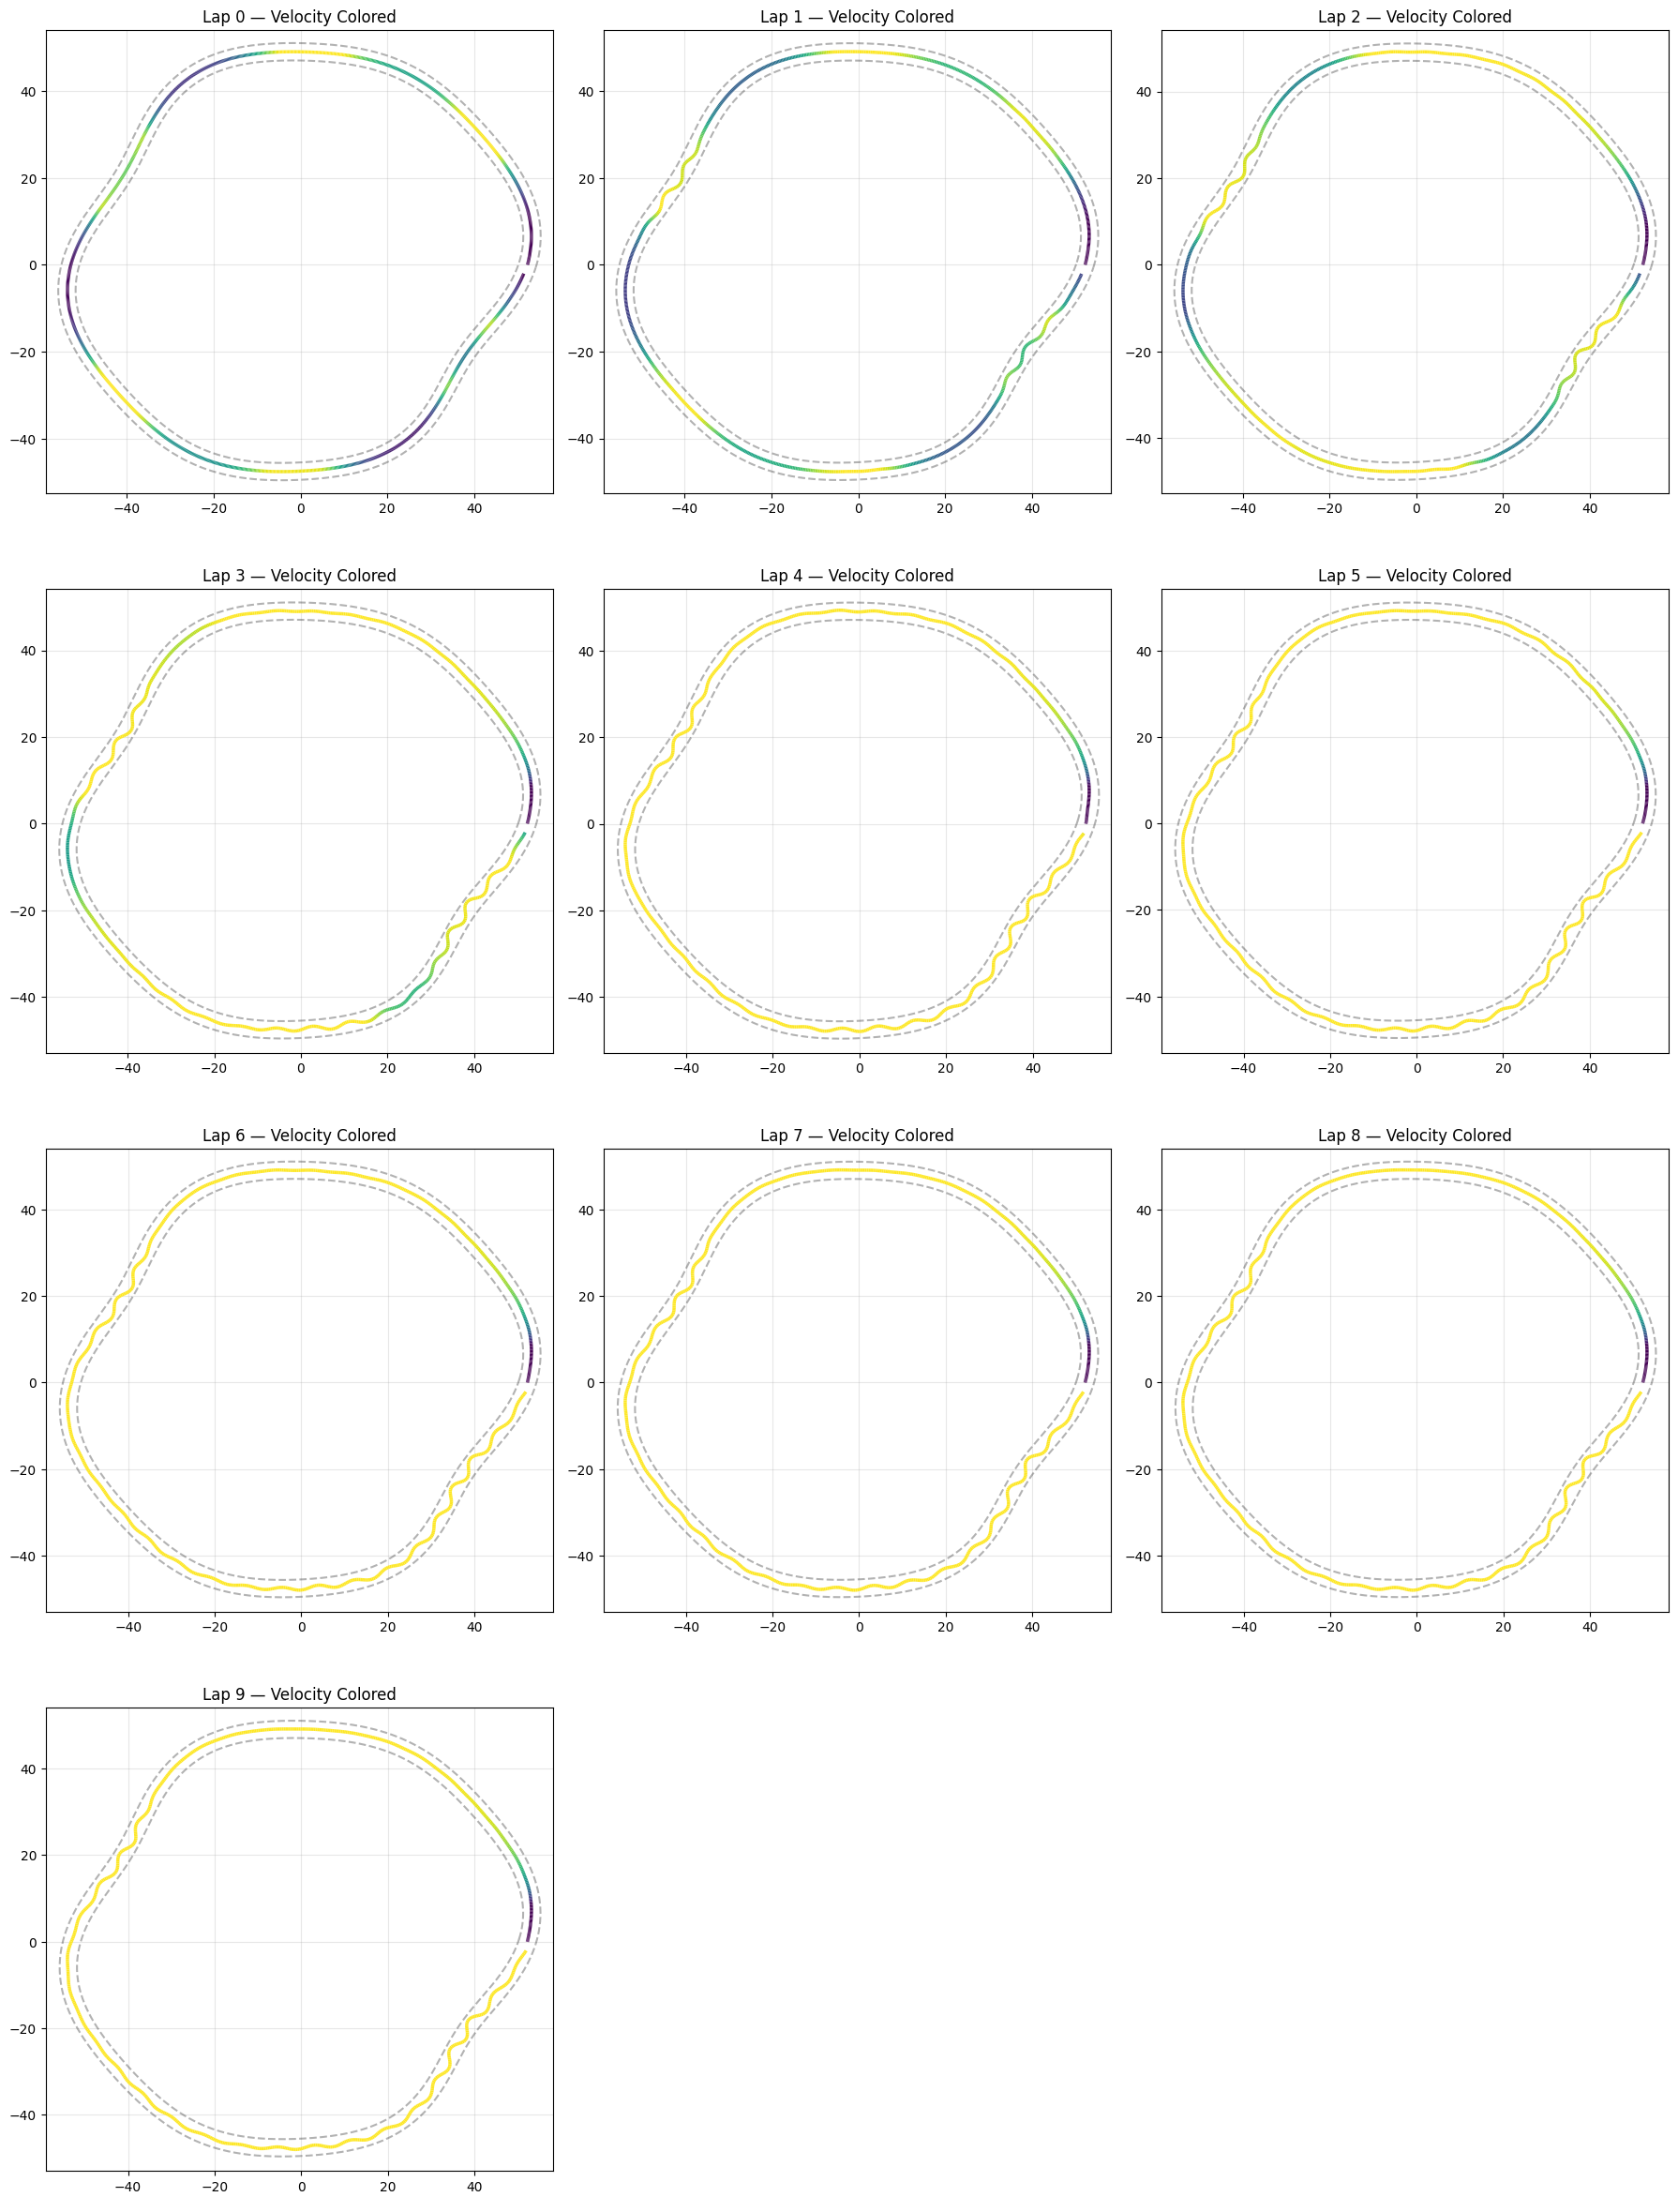

In [24]:
num_laps = len(all_laps)
cols = 3
rows = int(np.ceil(num_laps / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

for idx, (ax, lap) in enumerate(zip(axes, all_laps)):

    ax.set_title(f"Lap {idx} — Velocity Colored")

    # Track boundaries
    ax.plot(track.inner[:,0], track.inner[:,1], 'k--', alpha=0.3)
    ax.plot(track.outer[:,0], track.outer[:,1], 'k--', alpha=0.3)

    # Build segments
    pts = lap[:, :2].reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

    # Percentile-based normalization
    vmin = np.percentile(lap[:,2], 5)
    vmax = np.percentile(lap[:,2], 95)
    norm = plt.Normalize(vmin, vmax)

    lc = LineCollection(segs, cmap='viridis', norm=norm)
    lc.set_array(lap[:,2])
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    ax.set_xlim(np.min(lap[:,0]) - 5, np.max(lap[:,0]) + 5)
    ax.set_ylim(np.min(lap[:,1]) - 5, np.max(lap[:,1]) + 5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide extra axes
for ax in axes[num_laps:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

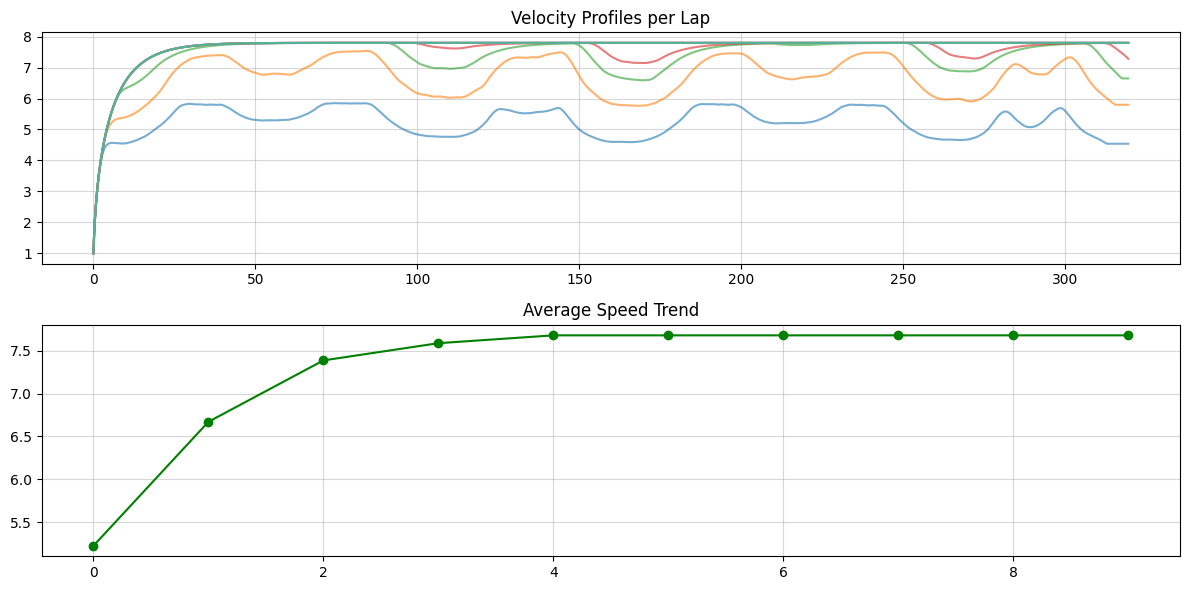

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 1)

ax_vel = fig.add_subplot(gs[0])
ax_vel.set_title("Velocity Profiles per Lap")

for lap in resampled:
    ax_vel.plot(global_d, lap[:,2], alpha=0.6)

ax_vel.grid(True, alpha=0.5)

ax_avg = fig.add_subplot(gs[1])
ax_avg.set_title("Average Speed Trend")

avg_vels = [np.mean(lap[:,2]) for lap in resampled]
ax_avg.plot(range(len(avg_vels)), avg_vels, "o-", color="green")

ax_avg.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------------------------
# Learning Model Predictive Control with Error-Dynamics Regression
# ----------------------------------------------------------------------
# This code draws conceptual inspiration from:
#
#   Haoru Xue, Edward L. Zhu, Francesco Borrelli
#   "Learning Model Predictive Control with Error Dynamics Regression
#    for Autonomous Racing"
#   arXiv:2309.10716 (2023)
#
# The paper introduces an LMPC framework that augments the nominal
# dynamics with a learned error model, enabling faster lap-time 
# convergence and improved control performance in autonomous racing.
#
# This implementation follows the same spirit: 
#   • nominal bicycle model
#   • error-model regression
#   • iterative lap-based learning
#   • closed-loop improvement across laps
#
# This is not a line-for-line reproduction; it is an adapted engineering
# version built for practical simulation and experimentation.
# ------------------------------------------------------------------------------